## Goals

- find the optimal model fit

## TODO

- [x] get the branchpoint PWM & initialize with it

## Get the data

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import data
import model
from helper import *
from concise.utils.model_data import split_train_test_idx, subset
from uuid import uuid4
import sklearn.metrics as skm
from concise.utils.pwm import PWM
import keras.callbacks as kc

Using TensorFlow backend.


## Get the data

In [335]:
param = {"data": {"n_bases": 20,
                 "truncate": True}, 
         "model":{},
         "fit": {"pos_cls_w": 2}}

In [336]:
train_raw, test = data.data(**param["data"])

In [337]:
train_idx, valid_idx = split_train_test_idx(train_raw, valid_split=.2, stratified=False, random_state=100)
valid = subset(train_raw, valid_idx, keep_other=False)
train = subset(train_raw, train_idx, keep_other=True)

In [338]:
# TODO - split validation by chromosomes?

In [339]:
np.intersect1d(valid_idx, train_idx)

array([], dtype=int64)

## Train the model

In [358]:
param["model"] = {"filters": 120,
                  "nonlinearity": "relu", #None, #"relu", #"relu",
                  "init_motifs": None, #{"use_pssm": True, "stddev": 0, "mean_max_scale": 0.0}, 
                  "pos_effect": {"l2_smooth": 0,#1e-10,
                                 "l2": 0,#1e-10,
                                 "use_bias": False,
                                 "merge": {"type": "concatenate",
                                          "hidden_fc": {"n_hidden": 20, 
                                                        "l1": 1e-10, 
                                                        "l2": 1e-10, 
                                                        "activation": "relu",
                                                        "dropout_rate": 0.2,
                                                        "n_layers": 3},
                                 }
                        },
                  "l1_weights": 0,
                  "lr": 0.002,
                 }
m = model.model(**{"train_data": train, **param["model"]})

cur_model = param2str(param)
tb = kc.TensorBoard(log_dir='./logs3/'+ cur_model,
                    histogram_freq=0, 
                    write_graph=False, 
                    write_images=True)
cur_model

'hid_d=0.2;use_pssm=None;n_bases=20;pos_cls_w=2;hid_nl=3;type=concat;lr=0.002;nl=relu;filt=120;hid_n=20;trunc=True;04af'

In [359]:
sample_weight = np.squeeze(np.where(train[1]==1, param["fit"]["pos_cls_w"], 1), -1)
m.fit(train[0], train[1], epochs=50, 
      batch_size=128,
      sample_weight = sample_weight,
      callbacks=[kc.EarlyStopping(patience=4), tb],
      validation_data=valid)
print("Done!")
tb=None

Train on 22433 samples, validate on 5609 samples
Epoch 1/50
22433/22433 [==============================] - 7s - loss: 0.3480 - accuracy: 0.9403 - f1: nan - precision: nan - sensitivity_1: 0.0032 - sensitivity_2: 0.0032 - specificity: 0.9973 - fdr: nan - val_loss: 0.1503 - val_accuracy: 0.9425 - val_f1: nan - val_precision: nan - val_sensitivity_1: 0.0000e+00 - val_sensitivity_2: 0.0000e+00 - val_specificity: 1.0000 - val_fdr: nan
Epoch 2/50
22433/22433 [==============================] - 6s - loss: 0.2266 - accuracy: 0.9427 - f1: nan - precision: nan - sensitivity_1: 0.0000e+00 - sensitivity_2: 0.0000e+00 - specificity: 1.0000 - fdr: nan - val_loss: 0.1387 - val_accuracy: 0.9425 - val_f1: nan - val_precision: nan - val_sensitivity_1: 0.0000e+00 - val_sensitivity_2: 0.0000e+00 - val_specificity: 1.0000 - val_fdr: nan
Epoch 3/50
22433/22433 [==============================] - 6s - loss: 0.2109 - accuracy: 0.9511 - f1: nan - precision: nan - sensitivity_1: 0.3724 - sensitivity_2: 0.3724 - s

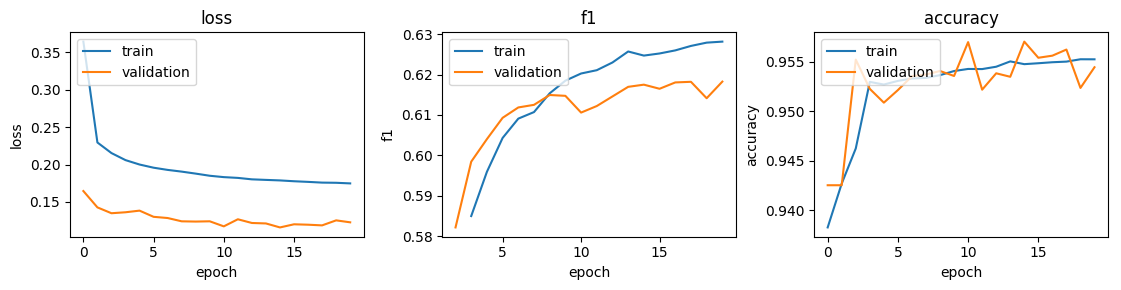

In [352]:
# summarize history for loss
score = "accuracy"
plt.figure(figsize=(15,3))
for i, score in enumerate(["loss", "f1", "accuracy"]):
    plt.subplot(1,4,i+1)
    plt.tight_layout()
    plt.plot(m.history.history[score], label="train")
    plt.plot(m.history.history['val_' + score], label="validation")
    plt.title(score)
    plt.ylabel(score)
    plt.xlabel('epoch')
    plt.legend(loc='best')
    

f1:  0.618420302253


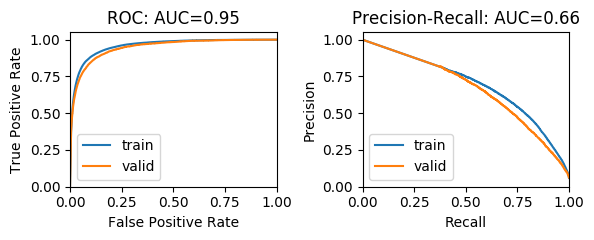

In [353]:
y_true = valid[1]
y_pred = m.predict(valid[0])
y_true_train = train[1]
y_pred_train = m.predict(train[0])
plt.figure(figsize=(6,2.5))
plt.subplot(121)
plot_roc_curve(y_true_train, y_pred_train, show=False)
plot_roc_curve(y_true, y_pred, show=False)
plt.legend(["train", "valid"])
plt.tight_layout()
plt.subplot(122)
plot_pr_curve(y_true_train, y_pred_train, show=False)

plot_pr_curve(y_true, y_pred, show=False)
plt.legend(["train", "valid"])
plt.tight_layout()
print("f1: ", cem.f1(y_true, y_pred))

f1:  0.562896244152


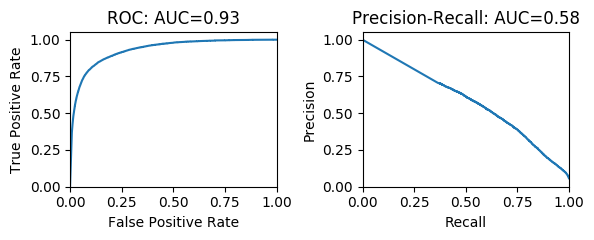

In [354]:
y_true = test[1]
y_pred = m.predict(test[0])
plt.figure(figsize=(6,2.5))
plt.subplot(121)
plot_roc_curve(y_true, y_pred, show=False)
plt.tight_layout()
plt.subplot(122)
plot_pr_curve(y_true, y_pred, show=False)
plt.tight_layout()
print("f1: ", cem.f1(y_true, y_pred))

## Inspect the model

### PWM

filter index: 0


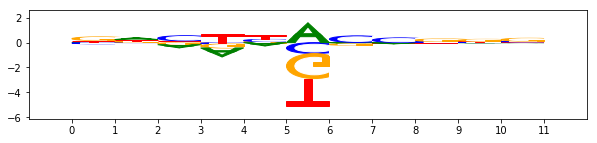

filter index: 1


/opt/modules/i12g/anaconda/3-4.1.1/envs/gpu-tensorflow/lib/python3.5/site-packages/matplotlib/axes/_base.py:3179: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


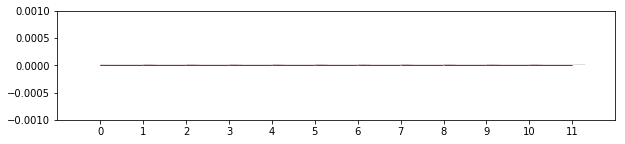

filter index: 2


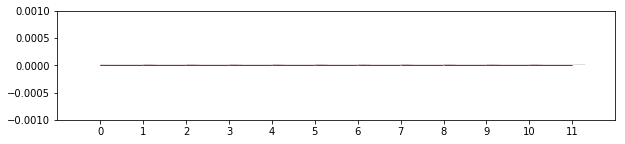

filter index: 3


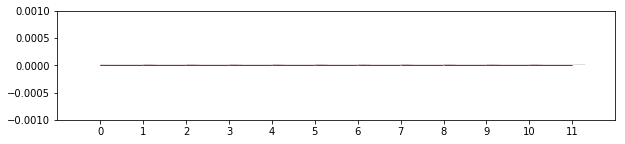

filter index: 4


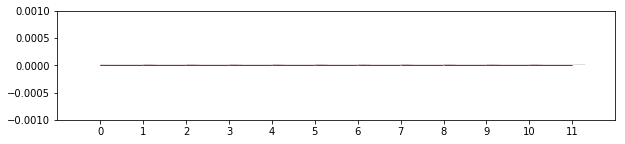

filter index: 5


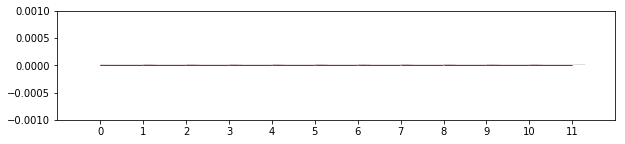

filter index: 6


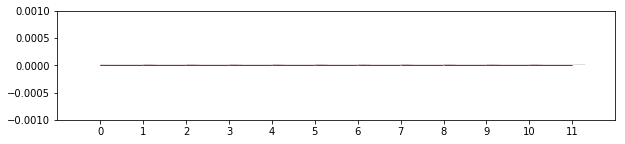

filter index: 7


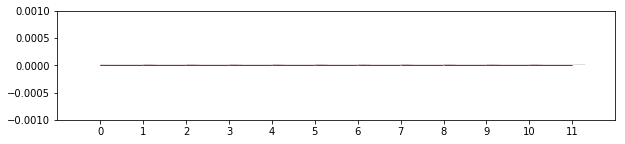

filter index: 8


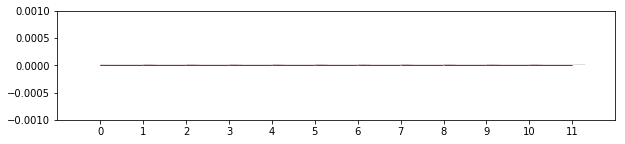

filter index: 9


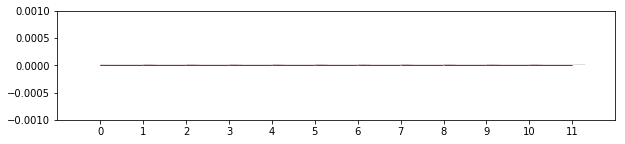

In [102]:
m.layers[10].plotFilters()

### Positional effects

In [327]:
x = train[0]["dist2"]

start = 18
end = 44

In [332]:
from concise.utils.splines import BSpline
#def plot_position(weights, x_train):
# start = np.nanmin(x)
# end = np.nanmax(x)
start = 0
end = 1
bs = BSpline(start, end, n_bases=20)
x_range = np.arange(start, end, (end-start) / 100)
X_pred = bs.predict(x_range)

In [333]:
train[2]

['dist1',
 'dist2',
 'ppt_start',
 'ppt_run_length',
 'canon_hit1',
 'canon_hit2',
 'canon_hit3',
 'canon_hit4',
 'canon_hit5']

In [334]:
m.get_layer("dist1")

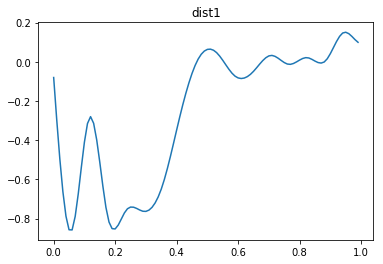

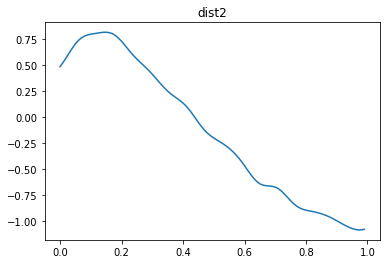

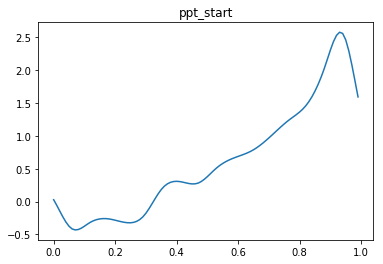

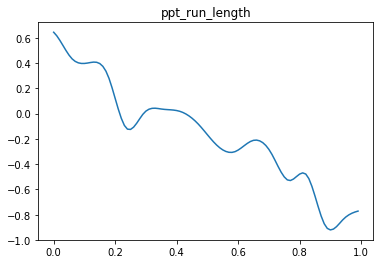

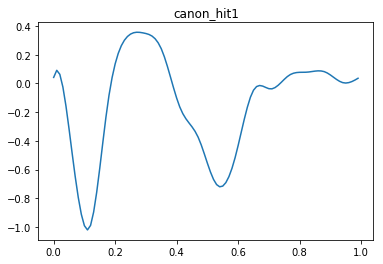

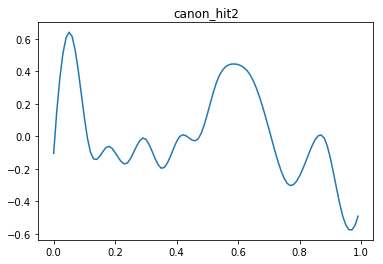

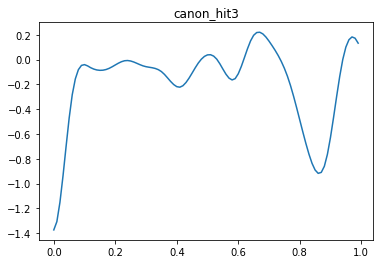

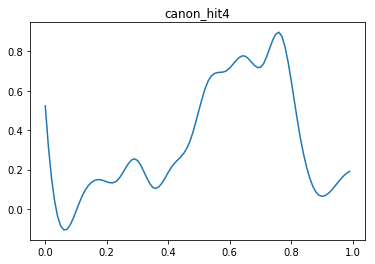

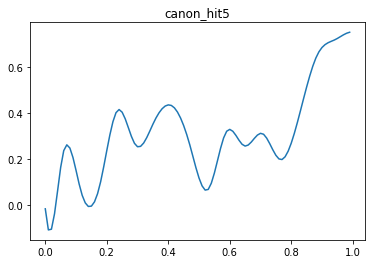

In [360]:
for i, l  in enumerate(train[2]):
    # TODO - refresh getting the layer by 
    layer = m.get_layer(l + "_conv")
    w = layer.get_weights()[0].reshape((-1,))
    y_pred = np.dot(X_pred, w)
    plt.plot(x_range, y_pred)
    plt.title(l)
    plt.show()

## Data sanity check

current_ration:  16.4372940722
pos_class_weight:  2.05466175903


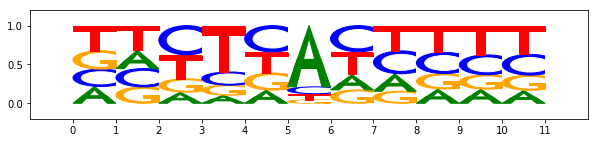

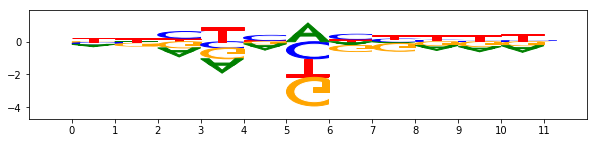

In [70]:
current_ratio = np.sum(train[1] == 0) / np.sum(train[1] == 1)
ideal_ratio = 8
pos_class_weight = current_ratio / ideal_ratio
print("current_ration: ", current_ratio)
print("pos_class_weight: ", pos_class_weight)
pwm_list = train[4]
pwm_list[0].plotPWM()
pwm_list[0].plotPSSM()

len(sample):  33689
seqs.shape:  (33689, 11, 4)


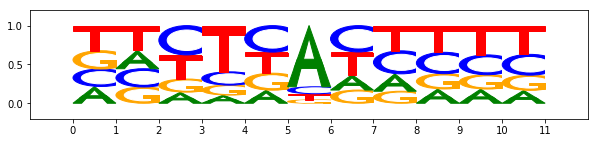

In [71]:
sample, pos, _ = np.where(train[1] == 1)
print("len(sample): ", len(sample))
seqs = np.array([train[0]["seq"][sample[i], (pos[i]):(pos[i]+11), :] 
                 for i in range(len(sample))])
print("seqs.shape: ", seqs.shape)
PWM(seqs.mean(0)).plotPWM()